# Stories frames and analysis of multiple documents

In [11]:
import re
from pathlib import Path
import pickle
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import spacy
from segram import Corpus, Story

# Use GPU acceleration for parsing documents if available
spacy.prefer_gpu()

# Paths
HERE = Path(".").absolute()
DATA = HERE/"data"

# Read dataset of articles coveriing the war in Syria
data = pd.read_csv(DATA/"FA-KES-Dataset.csv", encoding="latin")

# Sanitize beginnings of content strings to get rid of publication dates
# and other metadata. This is done using a few regular expressions
#
# Get rid of publication dates
pattern1 = r"^(" \
    r"\s*([A-Z]\w+)?\s*\d{1,2}\s*([A-Z]\w+)?\s*\d{2,4}\s*" \
    r"|" \
    r"\d{1,2}[-\.]\d{1,2}[-\.]\d{2,4}\s*" \
    r")" \
    r"(\s*at\s*\d+:?\d+)?"
# Get rid of update dates
pattern2 = r"^\s*(\(updated\s*[\w\d]*\s*\))\s*"
# Get rid of get url shout outs
pattern3 = r"^\s*get\s*short\s*url\s*([\d\w]+\s*)*"

# Sanitize the content column
data["article_content"] = data["article_content"] \
    .str.replace(pattern1, r"", regex=True) \
    .str.replace(pattern2, r"", regex=True, flags=re.IGNORECASE) \
    .str.replace(pattern3, r"", regex=True, flags=re.IGNORECASE) \
    .str.strip()

In [2]:
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("segram", config={
    "vectors": "en_core_web_lg"
})
nlp.add_pipe("segram_coref")

## Titles

In [3]:
fpath = DATA/"titles.segram"

if fpath.exists():
    titles = Corpus.from_disk(fpath, vocab=nlp.vocab)
else:
    titles = Corpus.from_texts(nlp, *data["article_title"], progress=True)
    titles.to_disk(fpath, nlp=False, vocab=False)

# Make sure word vectors are stored on CPU after parsing
# this is usually desirable when using semantic similarity methods
titles.ensure_cpu_vectors()
titles = Story(titles)

In [15]:
fpath = DATA/"titles.pkl"

if fpath.exists():
    with open(fpath, "rb") as fh:
        S = pickle.load(fh)
else:
    sents = titles.sents.tuple.filter(lambda s: s.text)
    sents[0].similarity(sents[1])
    S = np.zeros((len(sents), len(sents)), dtype=float)
    for i, si in tqdm(tuple(enumerate(sents))):
        for j, sj in enumerate(sents[:i]):
            S[i, j] = si.similarity(sj, method="phrases")
    S += S.T
    np.fill_diagonal(S, 1)
    S = (S + S.T) / 2
    with open(fpath, "wb") as fh:
        pickle.dump(S, fh)


L, V = np.linalg.eigh(S)
L = np.diag(np.clip(L, 0, None)[::-1])
V = V[:, ::-1]
Z = (V@np.sqrt(L))[:, :2]
var_explained = L.diagonal() / L.diagonal().sum()

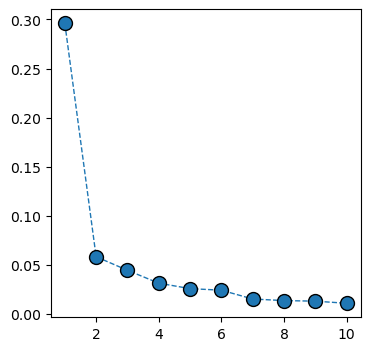

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))

var = var_explained[:10]
ax.plot(
    np.arange(1, len(var)+1), var,
    marker="o", markersize=10, markeredgecolor="black",
    ls="--", lw=1
)

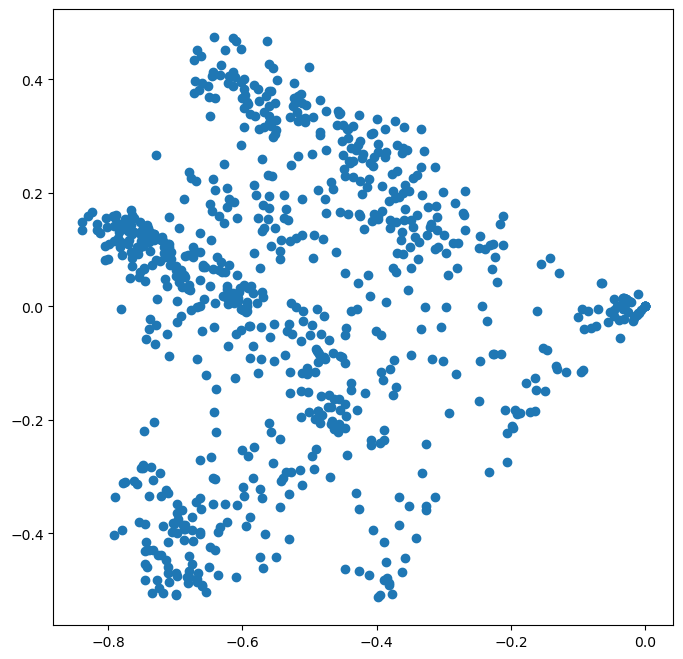

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(*Z.T)

## Articles

In [19]:
fpath = DATA/"articles.segram"
if fpath.exists():
    articles = Corpus.from_disk(fpath, vocab=nlp.vocab)
else:
    articles = Corpus.from_texts(nlp, *data["article_content"], progress=True)
    articles.to_disk(fpath, nlp=False, vocab=False)
# Make sure word vectors are stored on CPU after parsing
# this is usually desirable when using semantic similarity methods
articles.ensure_cpu_vectors()
articles = Story(articles)

In [ ]:
fpath = DATA/"articles.pkl"

if fpath.exists():
    with open(fpath, "rb") as fh:
        S = pickle.load(fh)
else:
    sents = articles.sents.tuple.filter(lambda s: s.text)
    sents[0].similarity(sents[1])
    S = np.zeros((len(sents), len(sents)), dtype=float)
    for i, si in tqdm(tuple(enumerate(sents))):
        for j, sj in enumerate(sents[:i]):
            S[i, j] = si.similarity(sj, method="phrases")
    S += S.T
    np.fill_diagonal(S, 1)
    S = (S + S.T) / 2
    with open(fpath, "wb") as fh:
        pickle.dump(S, fh)


L, V = np.linalg.eigh(S)
L = np.diag(np.clip(L, 0, None)[::-1])
V = V[:, ::-1]
Z = (V@np.sqrt(L))[:, :2]
var_explained = L.diagonal() / L.diagonal().sum()